In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)   # عرض كل الأعمدة
pd.set_option('display.max_colwidth', None)  # عرض كل الخانات بدون اختصار
pd.set_option('display.width', None)

In [2]:
df = pd.read_csv('data/hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Data Understanding

![Screenshot from 2025-11-23 15-42-48.png](<attachment:Screenshot from 2025-11-23 15-42-48.png>)
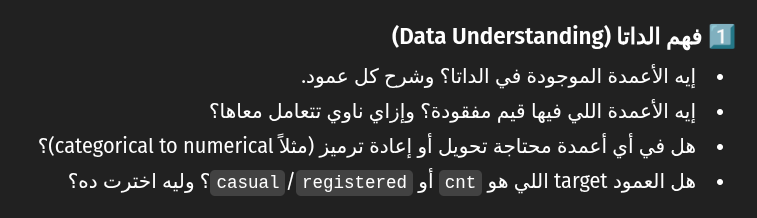

### Dataset characteristics

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [3]:
# Get columns with NA values
na_cols = [col for col in df.columns if df[col].isna().sum() > 0 ]
print(f"Columns with Null values: {na_cols}")


# Is there any columns that need any transformation or encoding?
SEASON = {1:'spring', 2:'summer', 3:'fall', 4:'winter'} # Mapping this dict with dataframe for getting insights
WEATHERSIT = {1:'clear', 2:'mist', 3:'light snow', 4:'heavy rain'} # Mapping this dict with dataframe for getting insights
NORMALIZE = {'temp':41, 'atemp':50, 'hum':100, 'windspeed':67} # Undo Normalize for getting real values, Before normalize
WORKDAY_OR_HOLIDAY = {0:'holiday', 1:'workday'}

def real_values(df):
    df = df.copy()
    for col, max_val in NORMALIZE.items():
        df[f"real_{col}"] = df[col] * max_val
    return df

df = real_values(df=df)

# Converting dtype to datetime type
df.dteday = pd.to_datetime(df.dteday, format='%Y-%m-%d')

# Getting real values
df['real_season'] = df.season.map(SEASON)
df['real_weathersit'] = df.weathersit.map(WEATHERSIT)
df['weekday_name'] = df.dteday.dt.day_name()
df['month_name'] = df.dteday.dt.month_name().str.slice(start=0, stop=3)
df['workday_or_holiday'] = df.workingday.map(WORKDAY_OR_HOLIDAY)

# Which feature I will select to be the target feature?
# I Will select "cnt" as target

Columns with Null values: []


![Screenshot from 2025-11-23 15-43-02.png](<attachment:Screenshot from 2025-11-23 15-43-02.png>)
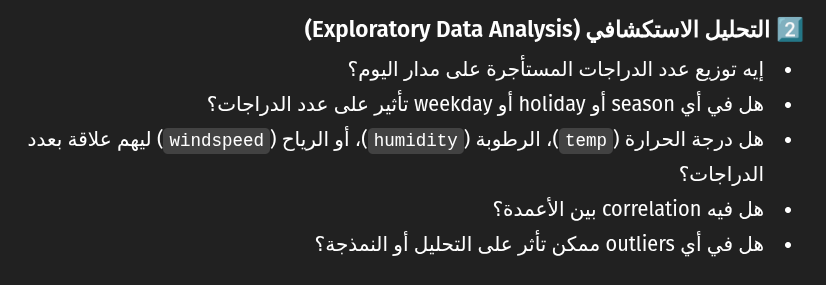

# Exploratory Data Analysis
- What is the distribution of the number of rented bicycles throughout the day?
- Does the season, holiday, or weekday affect the number of bikes rented?
- Do temperature, humidity, and wind affect the number of bicycles rented?
- Is there a connection between the columns?
- Are there any outliers that might affect the analysis or modeling?

In [4]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,real_temp,real_atemp,real_hum,real_windspeed,real_season,real_weathersit,weekday_name,month_name,workday_or_holiday
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,9.84,14.395,81.0,0.0,spring,clear,Saturday,Jan,holiday
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,9.02,13.635,80.0,0.0,spring,clear,Saturday,Jan,holiday
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,9.02,13.635,80.0,0.0,spring,clear,Saturday,Jan,holiday
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,9.84,14.395,75.0,0.0,spring,clear,Saturday,Jan,holiday
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,9.84,14.395,75.0,0.0,spring,clear,Saturday,Jan,holiday


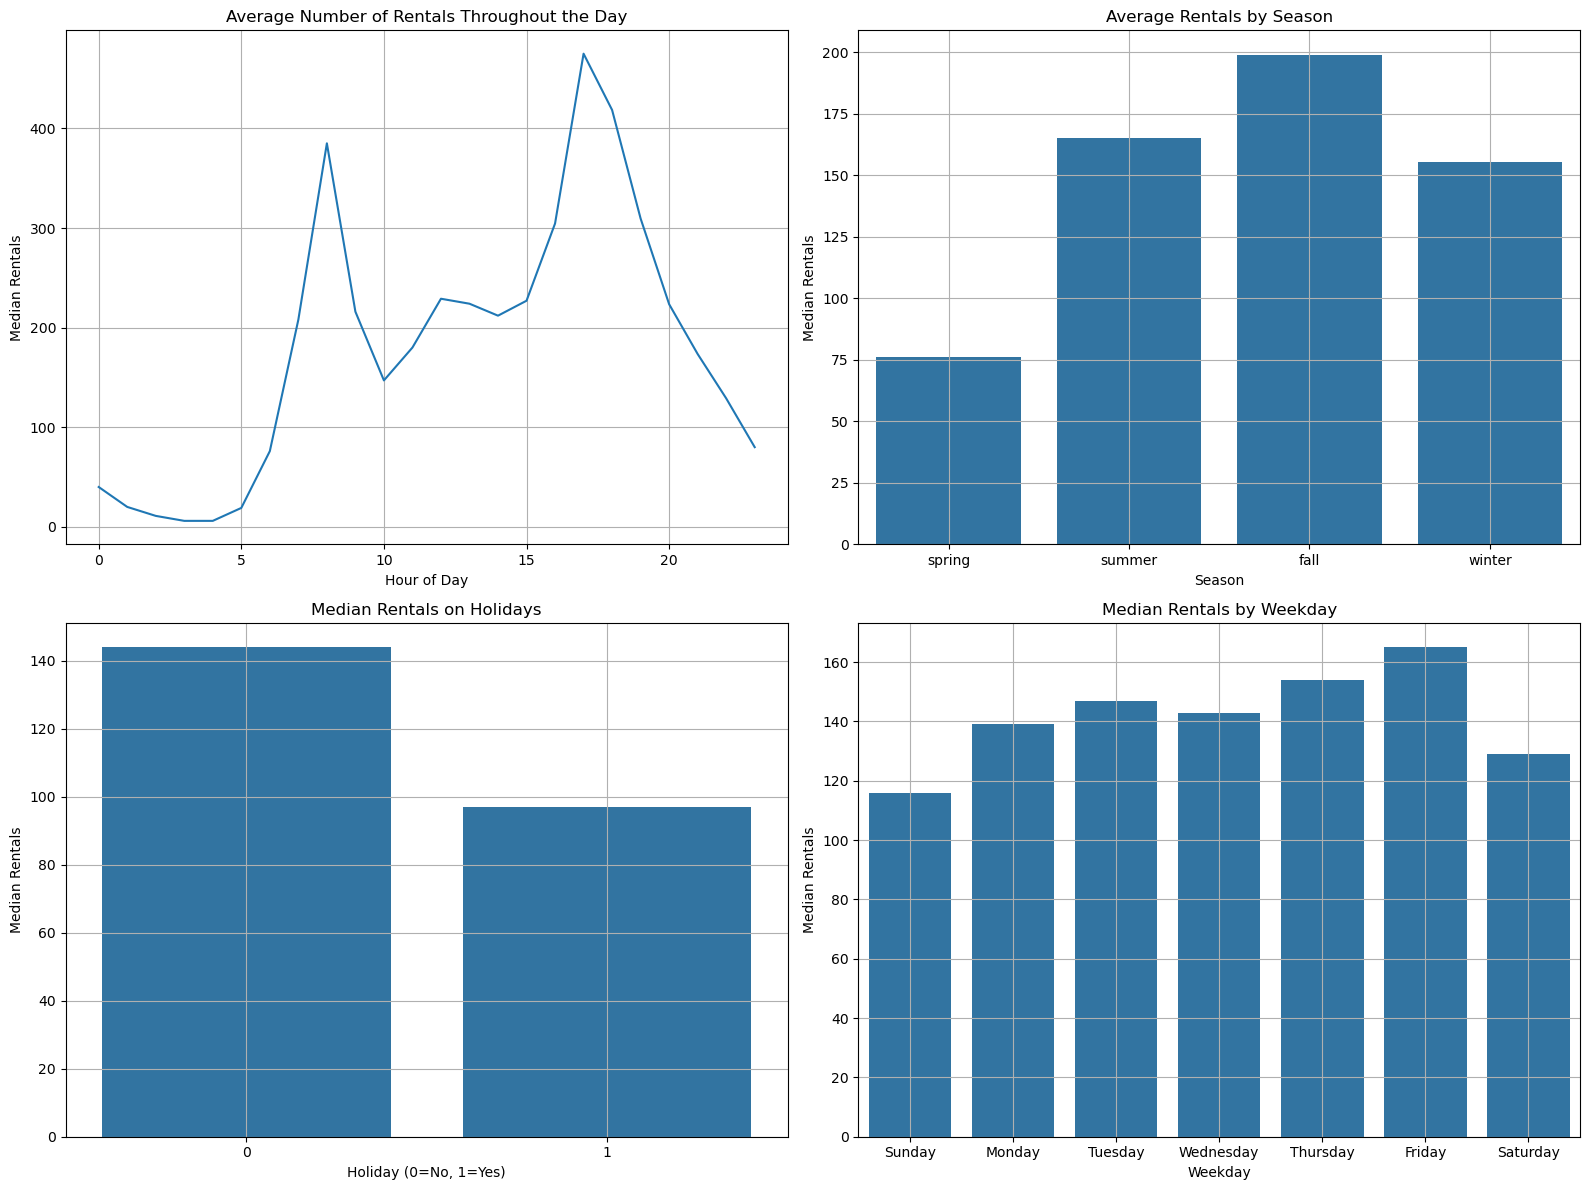

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# What is the distribution of the number of rented bicycles throughout the day?
# 1) Distribution of rentals throughout the day
hourly = df.groupby('hr')['cnt'].median()
sns.lineplot(x=hourly.index, y=hourly.values, ax=axes[0, 0])
axes[0, 0].set_title("Average Number of Rentals Throughout the Day")
axes[0, 0].set_xlabel("Hour of Day")
axes[0, 0].set_ylabel("Median Rentals")
axes[0, 0].grid(True)

# Does the season, holiday, or weekday affect the number of bikes rented?
# 2) Rentals by Season
season_order = ['spring', 'summer', 'fall', 'winter']
seasonal = df.groupby('real_season')['cnt'].median()
sns.barplot(x=seasonal.index, y=seasonal.values, order=season_order, ax=axes[0, 1])
axes[0, 1].set_title("Average Rentals by Season")
axes[0, 1].set_xlabel("Season")
axes[0, 1].set_ylabel("Median Rentals")
axes[0, 1].grid(True)

# 3) Rentals on Holidays vs Non-Holidays
holiday = df.groupby('holiday')['cnt'].median()
sns.barplot(x=holiday.index, y=holiday.values, ax=axes[1, 0])
axes[1, 0].set_title("Median Rentals on Holidays")
axes[1, 0].set_xlabel("Holiday (0=No, 1=Yes)")
axes[1, 0].set_ylabel("Median Rentals")
axes[1, 0].grid(True)

# 4) Rentals by Weekday
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekday = df.groupby('weekday_name')['cnt'].median()
sns.barplot(x=weekday.index, y=weekday.values, order=day_order, ax=axes[1, 1])
axes[1, 1].set_title("Median Rentals by Weekday")
axes[1, 1].set_xlabel("Weekday")
axes[1, 1].set_ylabel("Median Rentals")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

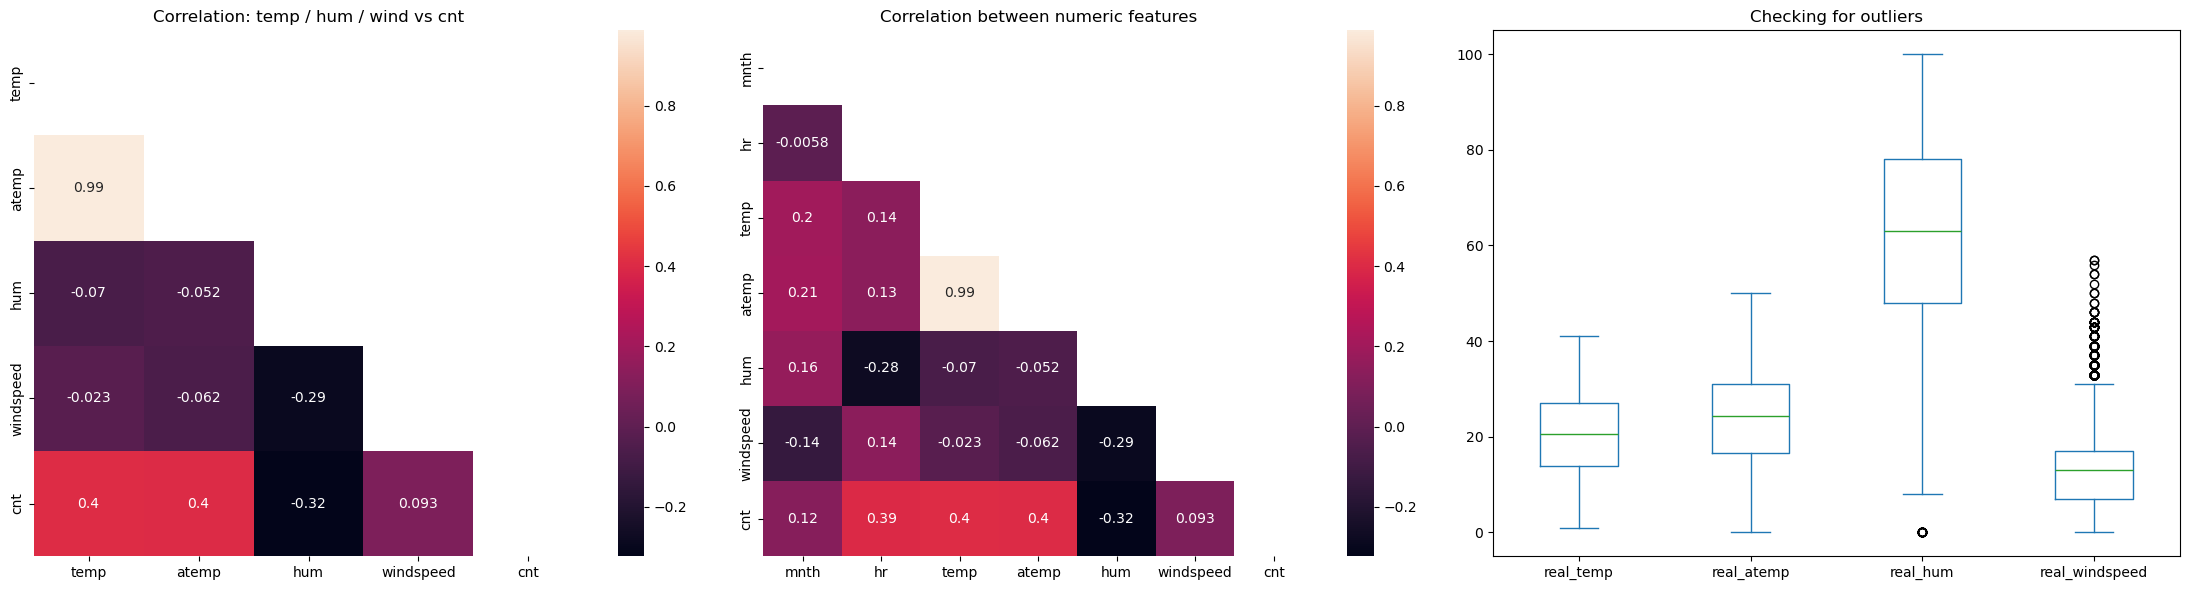

In [6]:
cat_cols = ['season', 'holiday', 'weekday', 'workingday', 'weathersit']
num_cols = ['mnth', 'hr', 'temp', 'atemp', 'hum', 'windspeed',
            'casual', 'registered', 'cnt']

num_cols2 = num_cols.copy()
num_cols2.remove('casual'); num_cols2.remove('registered')

fig, axes = plt.subplots(1, 3, figsize=(22, 6)
                         )
# Do temperature, humidity, and wind affect the number of bicycles rented?
# Correlation: temp, atemp, hum, windspeed vs cnt
affect_corr = df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()
affect_mask = np.triu(np.ones_like(affect_corr, dtype=bool))
sns.heatmap(affect_corr, annot=True, mask=affect_mask, ax=axes[0])
axes[0].set_title('Correlation: temp / hum / wind vs cnt')

# Is there a connection between the columns
# Correlation: all numerical columns 
corr = df[num_cols2].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, ax=axes[1])
axes[1].set_title("Correlation between numeric features")

# Are there any outliers that might affect the analysis or modeling?
# Boxplot: Outliers
df[['real_temp', 'real_atemp', 'real_hum', 'real_windspeed']].plot(
    kind='box', ax=axes[2]
)
axes[2].set_title("Checking for outliers")

plt.tight_layout()
plt.show()


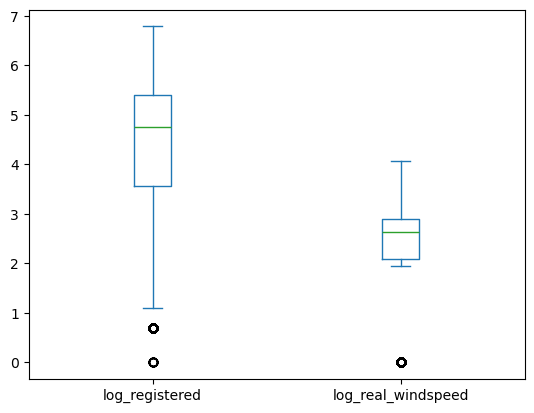

In [7]:
# Transforming columns with outliers (log(1 + x))
# df['log_casual'] = np.log1p(df['casual'])      # log(1 + x)
df['log_registered'] = np.log1p(df['registered'])
df['log_real_windspeed'] = np.log1p(df['real_windspeed'])

df[['log_registered', 'log_real_windspeed']].plot(kind='box')
plt.show()


![Screenshot from 2025-11-23 15-43-18.png](<attachment:Screenshot from 2025-11-23 15-43-18.png>)
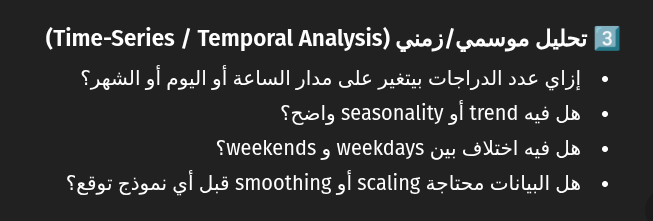

## Time-Series / Temporal Analysis
- How does the number of bicycles change over the course of an hour, day, or month?
- Is there any clear trend or seasonality?
- Is there any difference between weekdays and weekends?
- Is data needs scaling or smoothing before modeling?
* Official holidays are (Saturday, Sunday)

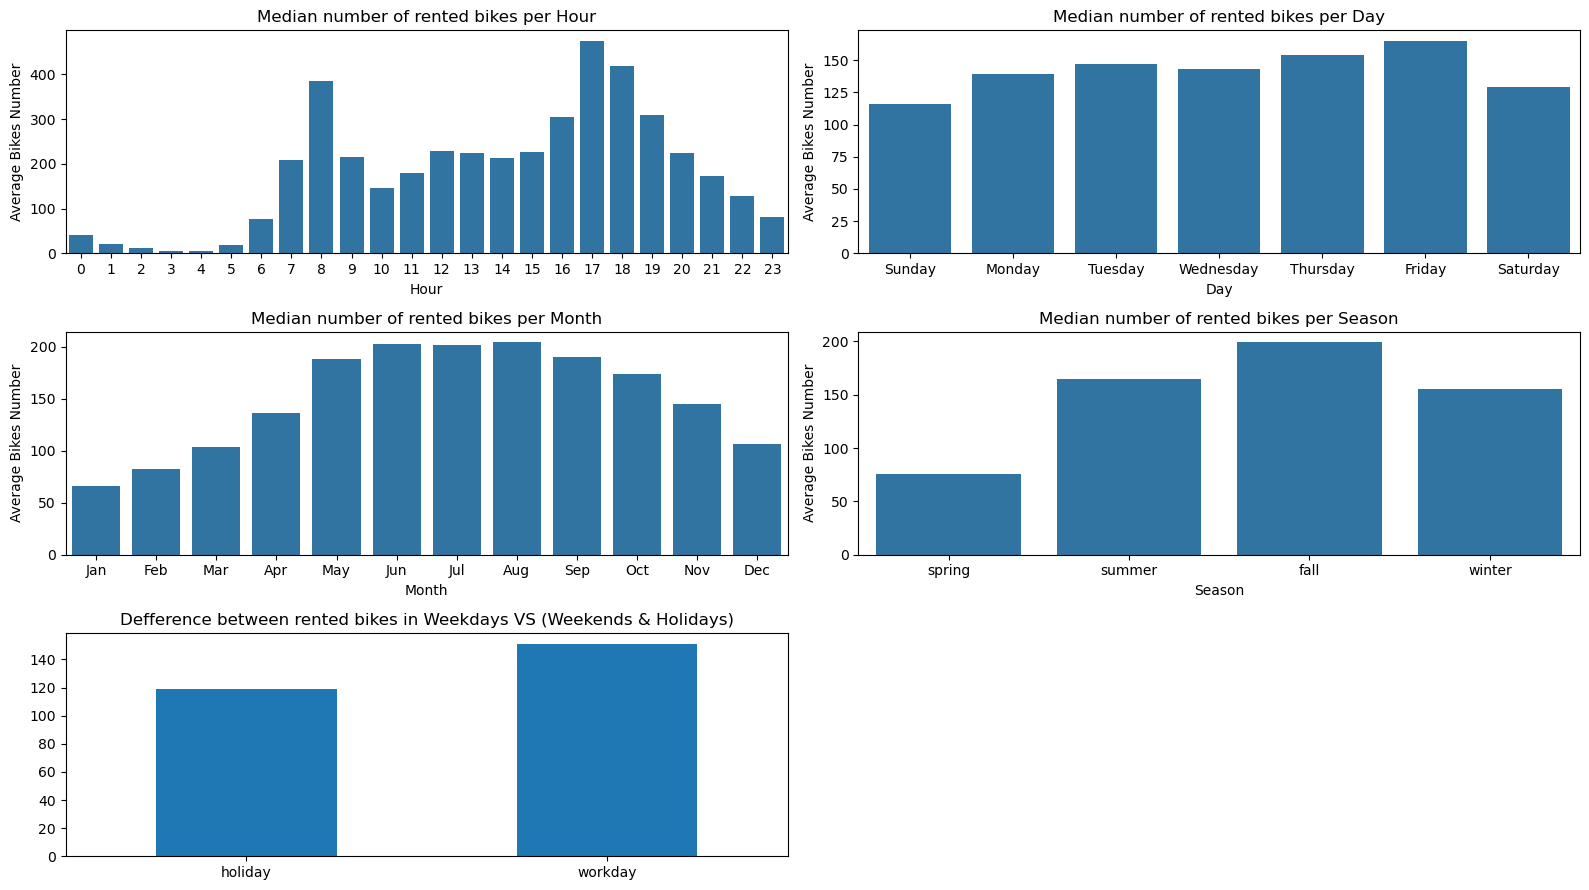

In [8]:
# How does the number of bicycles change over the course of an hour, day, or month?
fig, axes = plt.subplots(3, 2, figsize=(16, 9))
MEAN = 'mean'
MEDIAN = 'median'

# Rush Hours
rush_hours = df.groupby('hr', as_index=False).agg(mean_rented_bikes=('cnt', MEDIAN))
sns.barplot(data=rush_hours, x='hr', y='mean_rented_bikes', ax=axes[0, 0])
axes[0, 0].set_title('Median number of rented bikes per Hour')
axes[0, 0].set_ylabel("Average Bikes Number")
axes[0, 0].set_xlabel("Hour")

# Rush Days
rush_day = df.groupby('weekday_name', as_index=False).agg(mean_rented_bikes=('cnt', MEDIAN))
sns.barplot(data=rush_day, x='weekday_name', y='mean_rented_bikes', order=day_order, ax=axes[0, 1])
axes[0, 1].set_title('Median number of rented bikes per Day')
axes[0, 1].set_ylabel("Average Bikes Number")
axes[0, 1].set_xlabel("Day")

# Rush Months
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

rush_month = df.groupby('month_name', as_index=False).agg(mean_rented_bikes=('cnt', MEDIAN))
sns.barplot(data=rush_month, x='month_name', y='mean_rented_bikes', order=month_order, ax=axes[1, 0])
axes[1, 0].set_title('Median number of rented bikes per Month')
axes[1, 0].set_ylabel("Average Bikes Number")
axes[1, 0].set_xlabel("Month")


# Is there any clear trend or seasonality?
rush_season = df.groupby('real_season', as_index=False).agg(mean_rented_bikes=('cnt', MEDIAN))
sns.barplot(data=rush_season, x='real_season', y='mean_rented_bikes', order=season_order, ax=axes[1, 1])
axes[1, 1].set_title('Median number of rented bikes per Season')
axes[1, 1].set_ylabel("Average Bikes Number")
axes[1, 1].set_xlabel("Season")


# Is there any difference between weekdays and weekends?
# Mean rented bikes for working days vs non-working days
df.groupby('workday_or_holiday', as_index=False)['cnt'].median() \
  .rename(columns={'workday_or_holiday': 'is_working_day', 'cnt': 'mean_rented_bikes'}).plot(kind='bar', x='is_working_day', y='mean_rented_bikes', ax=axes[2, 0], legend=False)
axes[2, 0].set_title("Defference between rented bikes in Weekdays VS (Weekends & Holidays)")
axes[2, 0].set_xlabel('')
axes[2, 0].set_ylabel('')
axes[2, 0].tick_params(axis='x', rotation=0)


# Hide last empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Is data needs scaling or smoothing before modeling?
# Not realy because it normalized

![Screenshot from 2025-11-23 15-43-33.png](<attachment:Screenshot from 2025-11-23 15-43-33.png>)
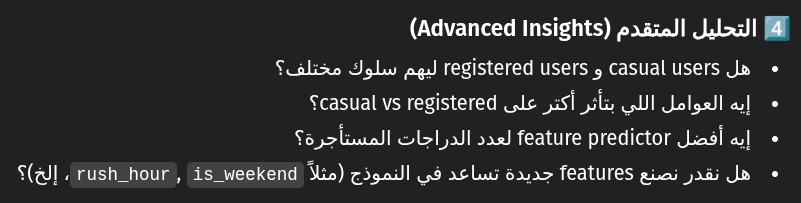

## Advanced Insights
- Is `Casual`, `Registered` Users have different behavior?
- What factors affect on `casual` vs `registered` Users?
- What is the best feature predictor number of bicycles to rent?
- Can we create a new feature to help the model? (is_weekend, rush_hour)

In [9]:
def melting_casual_registered(col:str): # Using (mean)
    rush_feature = df.groupby(col)[['casual', 'registered']].mean().reset_index()

    # melt to make hue work
    rush_melt = rush_feature.melt(id_vars=col,
                                    value_vars=['casual', 'registered'],
                                    var_name='user_type',
                                    value_name='median_rented_bikes')
    return rush_melt


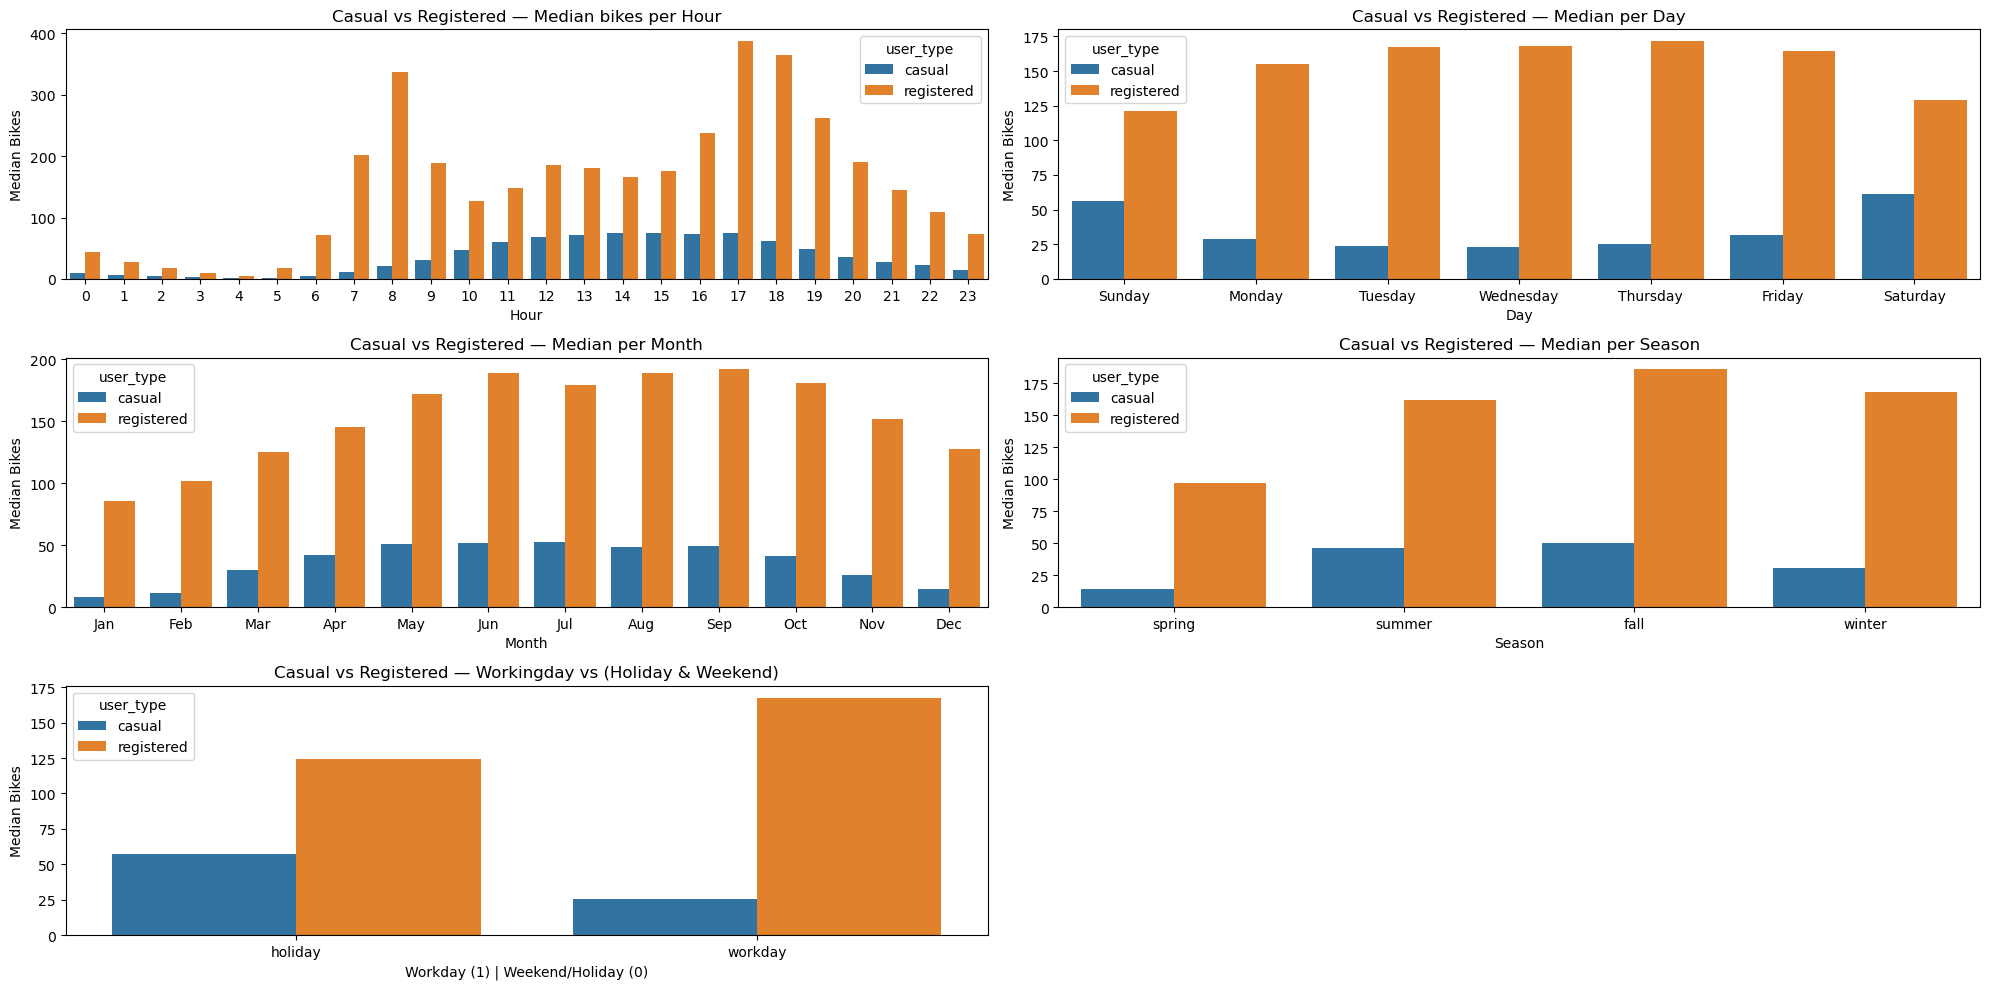

In [10]:
# Is `Casual`, `Registered` Users have different behavior?

fig, axes = plt.subplots(3, 2, figsize=(20, 10))

# Function already defined by you:
# melting_casual_registered(col)

# Hour 
rush_hours_melt = melting_casual_registered('hr')
sns.barplot(
    data=rush_hours_melt,
    x='hr',
    y='median_rented_bikes',
    hue='user_type',
    ax=axes[0, 0]
)
axes[0, 0].set_title('Casual vs Registered — Median bikes per Hour')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Median Bikes')

# Weekday Name
rush_weekdayname_melt = melting_casual_registered('weekday_name')
sns.barplot(
    data=rush_weekdayname_melt,
    x='weekday_name',
    y='median_rented_bikes',
    hue='user_type',
    order=day_order,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Casual vs Registered — Median per Day')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Median Bikes')

# Month Name 
rush_month_melt = melting_casual_registered('month_name')
sns.barplot(
    data=rush_month_melt,
    x='month_name',
    y='median_rented_bikes',
    hue='user_type',
    order=month_order,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Casual vs Registered — Median per Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Median Bikes')

# Season 
rush_season_melt = melting_casual_registered('real_season')
sns.barplot(
    data=rush_season_melt,
    x='real_season',
    y='median_rented_bikes',
    hue='user_type',
    order=season_order,
    ax=axes[1, 1]
)
axes[1, 1].set_title('Casual vs Registered — Median per Season')
axes[1, 1].set_xlabel('Season')
axes[1, 1].set_ylabel('Median Bikes')

# Working Day vs Holiday ---
rush_workday_melt = melting_casual_registered('workday_or_holiday')
sns.barplot(
    data=rush_workday_melt,
    x='workday_or_holiday',
    y='median_rented_bikes',
    hue='user_type',
    ax=axes[2, 0]
)
axes[2, 0].set_title("Casual vs Registered — Workingday vs (Holiday & Weekend)")
axes[2, 0].set_xlabel("Workday (1) | Weekend/Holiday (0)")
axes[2, 0].set_ylabel("Median Bikes")

# Hide last empty subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()


✔️ قبل ما تحكم إن "سلوك casual غير سلوك registered"

لازم تسأل:

هل الاختلاف ده بسبب different scales؟
(registered أكتر بكتير من casual)

ولا:

اختلاف حقيقي في behavior pattern per hour؟

وإنت بتتأكد من ده عن طريق:

1️⃣ normalizing
2️⃣ computing shares instead of counts
3️⃣ comparing patterns not raw numbers

# غير اعمده ساعات الذروه لبينارى 


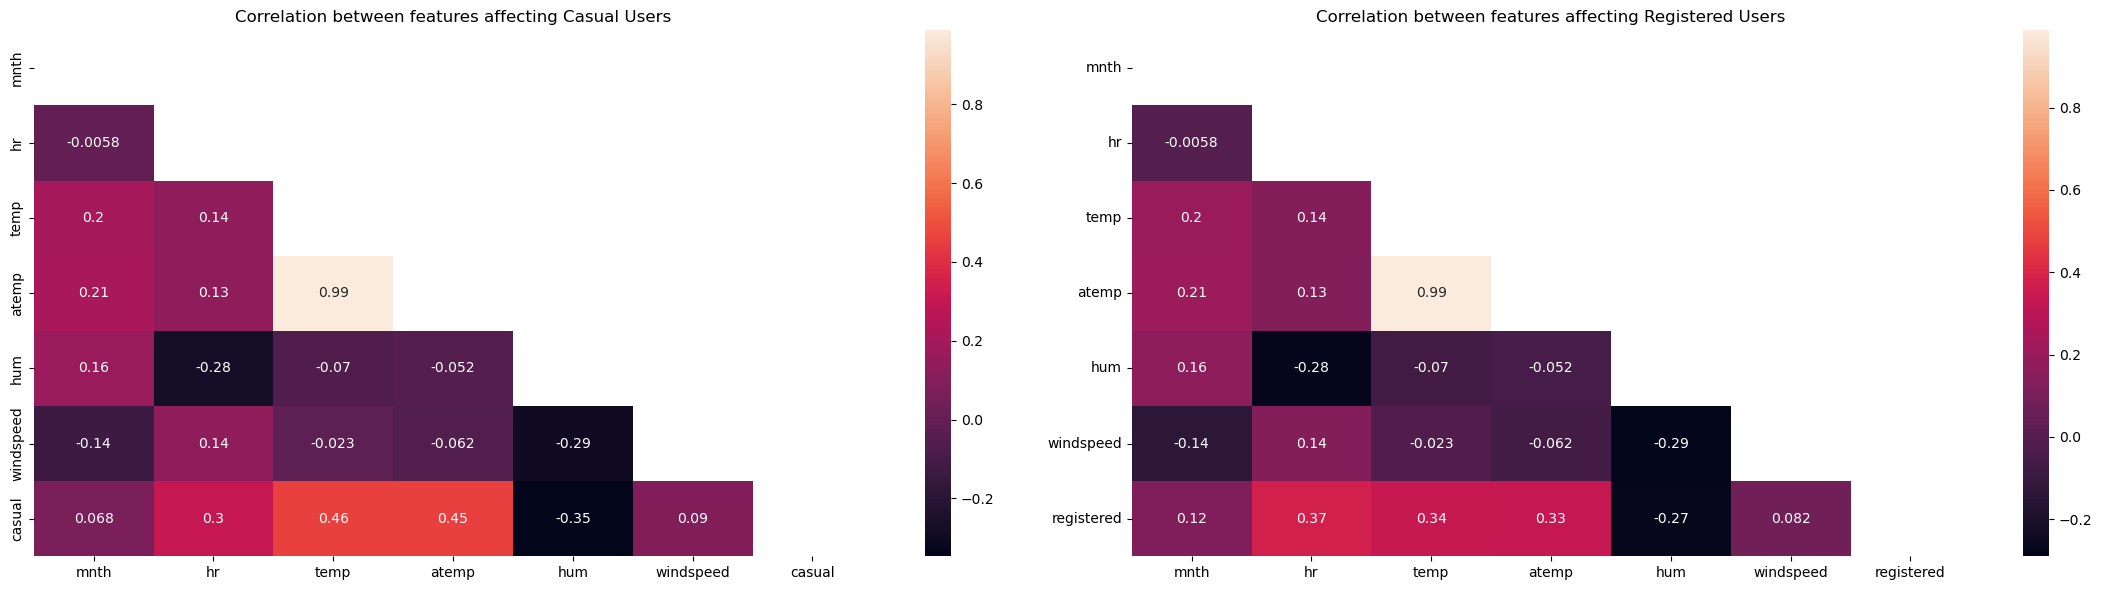

In [ ]:
# غير اعمده ساعات الذروه لبينارى 

# What factors affect on `casual` vs `registered` Users?
casual_users = num_cols.copy()
casual_users.remove('cnt'); casual_users.remove('registered')

registered_users = num_cols.copy()
registered_users.remove('cnt'); registered_users.remove('casual')

fig, axes = plt.subplots(1, 2, figsize=(22, 6))

# Correlation for Casual Users
affect_casual_corr = df[casual_users].corr()
affect_casual_mask = np.triu(np.ones_like(affect_casual_corr, dtype=bool))
sns.heatmap(affect_casual_corr, annot=True, mask=affect_casual_mask, ax=axes[0])
axes[0].set_title('Correlation between features affecting Casual Users')

# Correlation for Registered Users
affect_registered_corr = df[registered_users].corr()
affect_registered_mask = np.triu(np.ones_like(affect_registered_corr, dtype=bool))
sns.heatmap(affect_registered_corr, annot=True, mask=affect_registered_mask, ax=axes[1])
axes[1].set_title('Correlation between features affecting Registered Users')

plt.tight_layout()
plt.show()

# We can see that [hr, temp, atemp] have a positive relation with (casual, registered) users
# And [hum] have a negative relation with (casual, registered) users

# Can we create a new feature to help the model? (is_weekend, rush_hour)
# there is two columns (holiday & workingday) that can replace is_weekend
# So I can create a column that tells me if it is a rush hour or not for either (casual or registered) Users

# IS Rush hours for Registered Users

registered_rush_hrs = df.groupby('hr', as_index=False)['registered'].sum().sort_values('registered',ascending=False)['hr'].head().tolist()
df['registered_rush_hrs'] = df['hr'].isin(registered_rush_hrs).astype(int)


# IS Rush hours for Casual Users
casual_rush_hrs = df.groupby('hr', as_index=False)['casual'].sum().sort_values('casual',ascending=False)['hr'].head().tolist()
df['casual_rush_hrs'] = df['hr'].isin(registered_rush_hrs).astype(int)

# IS Rush hours for all users
cnt_rush_hrs = df.groupby('hr', as_index=False)['cnt'].sum().sort_values('cnt',ascending=False)['hr'].head().tolist()
df['cnt_rush_hrs'] = df['hr'].isin(registered_rush_hrs).astype(int)


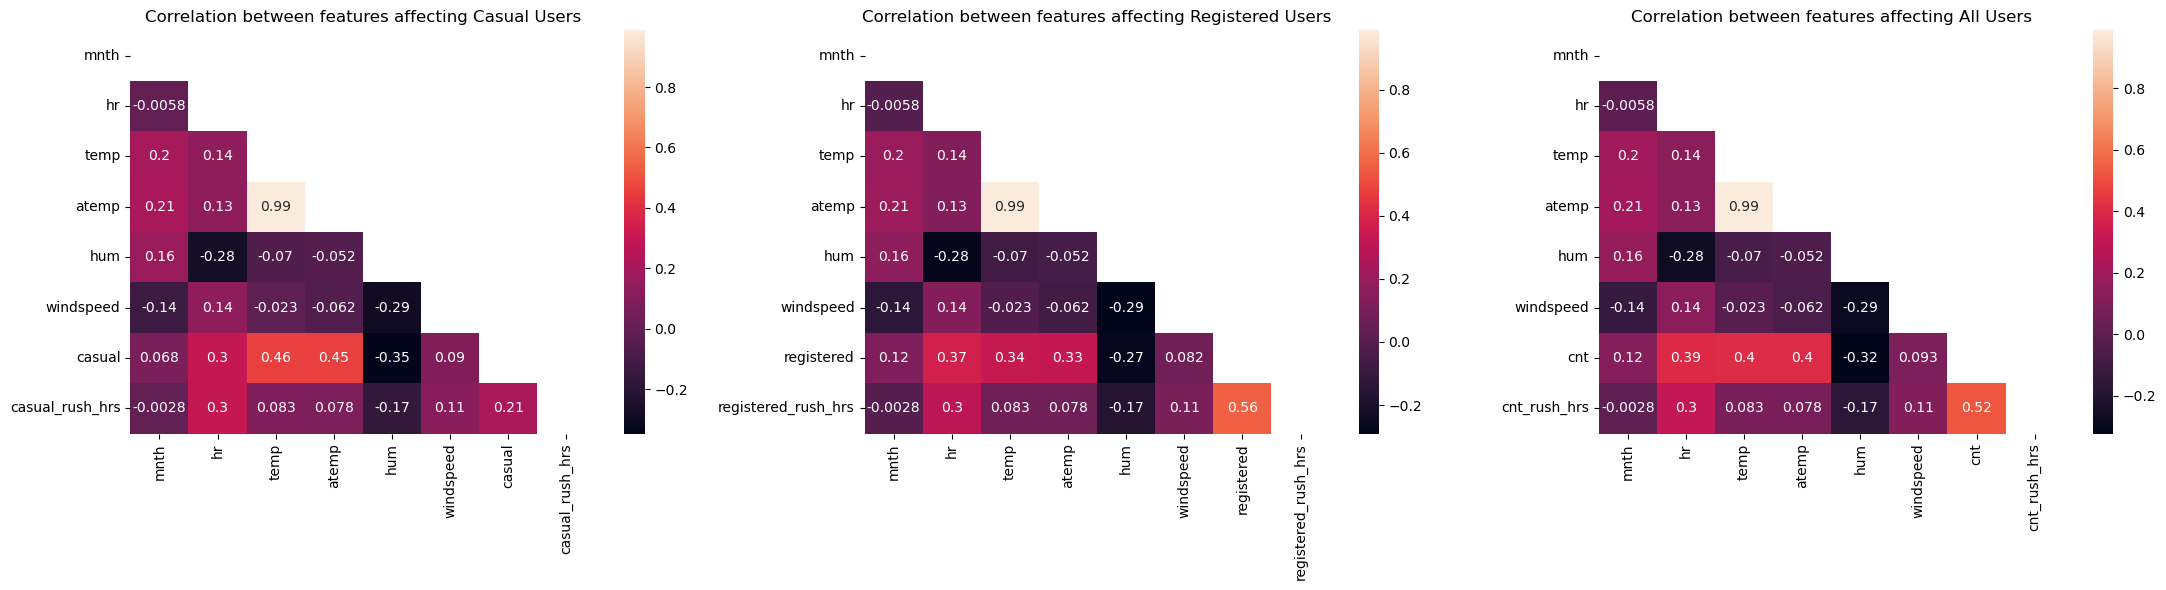

In [12]:
# What factors affect on `casual` vs `registered` Users?
casual_users = num_cols.copy()
casual_users.remove('cnt'); casual_users.remove('registered'); casual_users.append('casual_rush_hrs')

registered_users = num_cols.copy()
registered_users.remove('cnt'); registered_users.remove('casual'); registered_users.append('registered_rush_hrs')


fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Correlation for Casual Users
affect_casual_corr = df[casual_users].corr()
affect_casual_mask = np.triu(np.ones_like(affect_casual_corr, dtype=bool))
sns.heatmap(affect_casual_corr, annot=True, mask=affect_casual_mask, ax=axes[0])
axes[0].set_title('Correlation between features affecting Casual Users')

# Correlation for Registered Users
affect_registered_corr = df[registered_users].corr()
affect_registered_mask = np.triu(np.ones_like(affect_registered_corr, dtype=bool))
sns.heatmap(affect_registered_corr, annot=True, mask=affect_registered_mask, ax=axes[1])
axes[1].set_title('Correlation between features affecting Registered Users')

# Correlation for all Users
num_cols.append('cnt_rush_hrs')
all_users_num_cols = num_cols.copy(); all_users_num_cols.remove('casual'); all_users_num_cols.remove('registered')
affect_user_corr = df[all_users_num_cols].corr()
affect_user_mask = np.triu(np.ones_like(affect_user_corr, dtype=bool))
sns.heatmap(affect_user_corr, annot=True, mask=affect_user_mask, ax=axes[2])
axes[2].set_title('Correlation between features affecting All Users')
axes[2].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

## Understanding the relationship between categorical columns
- Using Chi-Square test to know if there is a relationship or not
- Then Using Cramers_v to determine the strength of the relationship between the category columns

In [13]:
from scipy.stats import chi2_contingency

cat_cols = ['season', 'holiday', 'weekday', 'workingday', 'weathersit']

chi2_pvals = pd.DataFrame(index=cat_cols, columns=cat_cols)

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            chi2_pvals.loc[col1, col2] = 1.0 
        else:
            contingency = pd.crosstab(df[col1], df[col2])
            chi2, p, dof, expected = chi2_contingency(contingency)
            chi2_pvals.loc[col1, col2] = p

chi2_pvals = chi2_pvals.astype(float)

print("Chi-square p-values matrix for categorical columns:")
display(chi2_pvals)


Chi-square p-values matrix for categorical columns:


,season,holiday,weekday,workingday,weathersit
season,1.000000e+00,9.038993e-08,8.050064e-01,1.299531e-04,1.162626e-31
holiday,9.038993e-08,1.000000e+00,5.337493e-301,3.429444e-242,2.000137e-02
weekday,8.050064e-01,5.337493e-301,1.000000e+00,0.000000e+00,4.507974e-16
workingday,1.299531e-04,3.429444e-242,0.000000e+00,1.000000e+00,1.315144e-07
weathersit,1.162626e-31,2.000137e-02,4.507974e-16,1.315144e-07,1.000000e+00


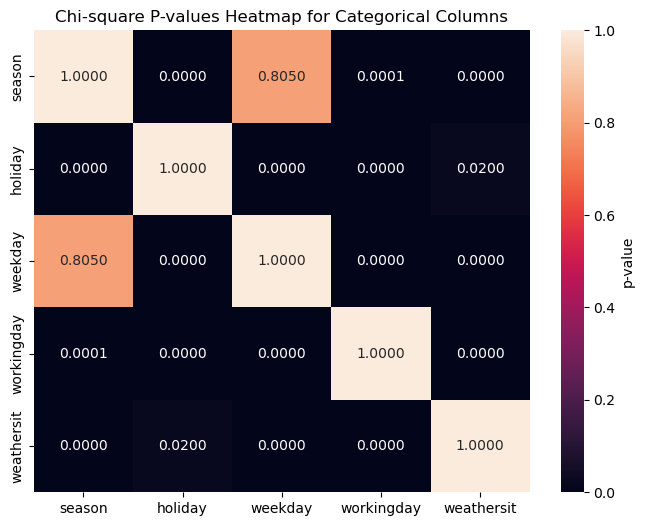

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(
    chi2_pvals,
    annot=True,
    fmt=".4f",
    # cmap="coolwarm_r",  
    cbar_kws={'label': 'p-value'}
)
plt.title("Chi-square P-values Heatmap for Categorical Columns")
plt.show()

In [15]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]  
    n = confusion_matrix.sum().sum()              
    r, k = confusion_matrix.shape                 
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cat_cols = ['season', 'holiday', 'weekday', 'workingday', 'weathersit']

for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        v = cramers_v(df[col1], df[col2])
        print(f"Cramér's V between {col1} and {col2}: {v:.3f}")


Cramér's V between season and holiday: 0.045
Cramér's V between season and weekday: 0.016


Cramér's V between season and workingday: 0.034
Cramér's V between season and weathersit: 0.057
Cramér's V between holiday and weekday: 0.285
Cramér's V between holiday and workingday: 0.252
Cramér's V between holiday and weathersit: 0.024
Cramér's V between weekday and workingday: 0.939
Cramér's V between weekday and weathersit: 0.047
Cramér's V between workingday and weathersit: 0.045


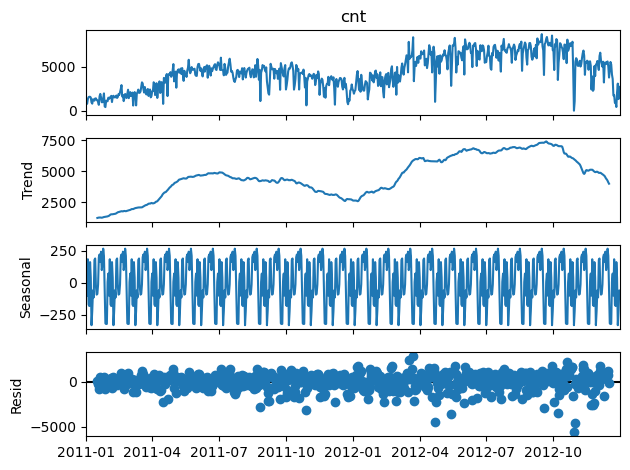

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

df_daily = df.groupby('dteday')['cnt'].sum()

result = seasonal_decompose(df_daily, model='additive', period=30)
result.plot()
plt.show()


![Screenshot from 2025-11-23 15-43-46.png](<attachment:Screenshot from 2025-11-23 15-43-46.png>)
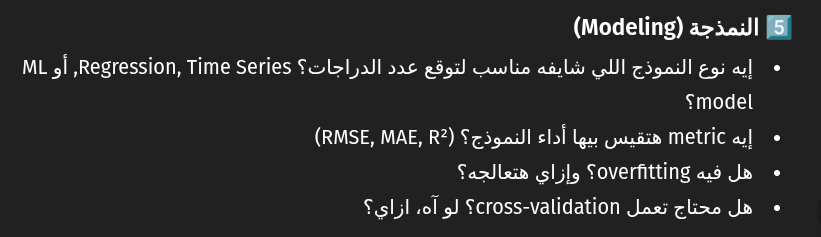

## Modeling
- What type of model do you think is suitable for predicting the number of bicycles? [Time Series, Regression, ML model]
- What matrix will you use to measure the model's performance? [R2_score, MAE, RMSE]
- If there is overfitting, how will you fix it?
- Do you need to do cross-validation? If so, how?

    * Regression model
    * feature Engineering
    * Feature Importance
    * Time series Trend / Seasonal Decomposition

![Screenshot from 2025-11-23 15-43-59.png](<attachment:Screenshot from 2025-11-23 15-43-59.png>)
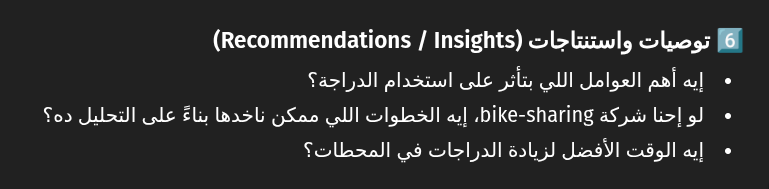

## Recommendation / Insights
- What are the most important factors that influence bicycle usage?
- If we were a bike-sharing company, what steps could we take based on this analysis?
- What is the best time to increase the number of bicycles at stations?